# Frequently record weather data in your EC2 instance 

## Introduction (10 minutes)

**Business context.** You are an independent consultant working for multiple clients. One of your clients specializes in environmental research and they have approached you with a new requirement. They would like to keep track of the weather of New York and record how it changes over a period of time. They would like your help on fetching the weather data every hour from an API and storing that in an EC2 instance. Along with storing the weather data, they would also like you to generate certain plots and store them in the EC2 machine as well.

**Business Problem.** Your task is to write Python scripts that would fetch the weather data from API, parse the data and store it in csv files in the same instance. You would also generate certain plots as mentioned below and store that as well in the same instance.

**Analytical Context.** The client wants you to fetch the data from [Dark Sky API](https://darksky.net). You would be registering to this service, and using the API Key from the website to pull out the weather data every hour. The steps to be followed are:

- Register in the Dark Sky website and receive the API Key
- Write a Python script that fetches the weather data and stores it in a json file
- Write another Python script that reads the stored json file, parses it and stores it as a csv file. The following steps need to be done for parsing:
    - The datetime options are returned in timestamp format. That has to be converted to a proper human readable format.
- After the csv file is stored, provide the following:
    - The minimum and maximum temperature in the next 48 hours
    - A line graph of how the temperature would change in the next 48 hours
    - A line graph of how the wind speed will change across 48 hours
- Once the Python scripts are done, create a bash script that calls these functions.
- Setup a cron job on the machine to execute every hour. The cron job should call the bash script, which will in turn call these 2 Python scripts.

## Launching an EC2 instance on AWS (10 minutes)

### What is Amazon EC2?

Virtual servers offered as a web-service that are highly configurable, scalable, and accessible via a point-and-click management console on AWS. Amazon has eliminated much of the heavy lifting traditionally required to set up the hardware, software, memory, networking, permissions, storage, security, etc. needed for dedicated computation while maintaining an abundant set of configuration options allowing you to tailor your server to your specific needs. 

### When to use EC2 as a Data Scientist?

- For computationally expensive tasks that your personal machine cannot handle
- For time consuming tasks you want to run in parallel without sacrificing performance on your personal machine
- For repetitive tasks that need to run automatically -- based on time, constraints, or external signals from other web-services or systems. 

### What are the configuration options?

Too many to fully explore each in detail as part of this case but as we walk through setting up and connecting to an instance we will touch upon the major categories of options available and provide resources for further exploration.

#### OK. Let’s set one up!

1. Start by signing in to [AWS](https://signin.aws.amazon.com/signin?redirect_uri=https%3A%2F%2Fconsole.aws.amazon.com%2Fconsole%2Fhome%3Fnc2%3Dh_ct%26src%3Dheader-signin%26state%3DhashArgs%2523%26isauthcode%3Dtrue&client_id=arn%3Aaws%3Aiam%3A%3A015428540659%3Auser%2Fhomepage&forceMobileApp=0) using your root user credentials. If you have not created your own AWS account, please consult with your TA to obtain the relevant instructions.

2. Navigate to the EC2 Management Console (Services > Compute > EC2) and click the “Launch Instance” button.
![img1](aws_ec2_img1.png)

3. You are now shown a wizard that will walk you through the major categories of options required to configure your instance. To begin, we must choose an Amazon Machine Image (AMI). This is essentially a template that describes the operating system, application server, and any additional software packages we want pre-installed on our virtual server. There are many AMI’s, some created and supported by Amazon, others by community users, and many that have been optimized for specific purposes so we urge you to read the descriptions of each. For the sake of this case, we will choose **Amazon Linux AMI 2018.03.0 (HVM), SSD Volume Type**
![img2](aws_ec2_img2.png)

4. Next, we are asked to specify the instance type. There is a wide selection of types which vary in CPU size, memory, storage, and networking capacity and are broadly organized into four families: Storage optimized, Memory optimized, Compute optimized, or General Purpose. For now we’re going to choose a small, General Purpose instance type. 
![img3](aws_ec2_img3.png)

5. For further configuration, you can explore steps 3-7 but for now let’s accept the default configuration and click the “Review and Launch” button followed by “Launch”.
![img4](aws_ec2_img4.png)

6. Select “Create a new key pair”, name it, download it, and then Launch the instance.
![img5](aws_ec2_img5.png)

7. Now lets connect to your freshly launched instance using SSH and the key pair you just downloaded by following steps outlined [here](https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/AccessingInstancesLinux.html)

## Registering with the DarkSky API (5 minutes)

In order to register with the Dark Sky API, visit - https://darksky.net/dev and click on Sign up. Once you register on the site and verify your email address, you can login to the site and see the API Key in the landing page after login.

## Fetch data from Dark Sky API (15 minutes)

Let's write a Python script to fetch the weather data from Dark Sky API. The API documentation for Dark Sky can be found here - https://darksky.net/dev/docs#forecast-request. We will be using this forecast endpoint to fetch the current weather conditions of New York. When calling this endpoint, we would have to provide the latitude and longitude of the location for which we need the weather status. You will need to pass the coordinates of New York. Which are - `40.7128,-74.0060`.

In your home folder, let's create a file named `fetch_weather_data.py` which will fetch the weather data and store it in a json file locally. The json file should be stored in the following folder structure - `darksky_data/raw_data/`. The file name should be of the following format - `weather_{datetime}.json`. Where datetime is the time for which the data is fetched. It can be found inside the `currently` key in the response.

The file should also be written to `darksky_data/raw_data/weather.json`, for the second script to be able to easily find the latest file to read and execute.

The sample of the file can be found below.

In [1]:
import datetime
import json
import os
import requests

DARKSKY_API_KEY = '05a2c6089865d0cd188e38a7d58bd4ce'
WEATHER_LOCATION_COORDINATES = '40.7128,-74.0060'

# First, check if the data folder is present. If not, create it
data_folder = 'darksky_data/raw_data'
if not os.path.isdir(data_folder):
    os.makedirs(data_folder)
    
# Generate the URL
url = 'https://api.darksky.net/forecast/{0}/{1}'.format(DARKSKY_API_KEY, WEATHER_LOCATION_COORDINATES)
response = requests.get(url)

weather_data = response.json()
current_datetime = datetime.datetime.fromtimestamp(weather_data['currently']['time']).strftime('%Y_%m_%d_%H_%M')
filename = os.path.join(data_folder, 'weather_{0}.json'.format(current_datetime))
with open(filename, 'w+') as f:
    f.write(json.dumps(weather_data))
    
latest_filename = os.path.join(data_folder, 'weather.json')
with open(latest_filename, 'w+') as f:
    f.write(json.dumps(weather_data))

## Parsing and visualizing the raw data

For the next section, we will be parsing the raw json data to convert it to a pandas dataframe, perform some operations on it. After that, we will be writing the csv to a local file and then perform operations on it. We will be:

- Calculating the predicted max, min and average temperature for the next 48 hours
- Calculate the predicted max, min and average wind speed for the next 48 hours
- Draw a line graph on how the temperature would vary in the next 48 hours
- Draw a line graph on how the wind speed would vary in the next 48 hours.

The output of each section should be stored to a file.

For each of the operations, we will be writing functions here and you will have to create a python file in the EC2 instance that calls all these functions.

## Parse raw data (5 minutes)

In this section, we will create a function that will read the latest json file (with the name `weather.json`), and convert the time from timestamp into a proper datetime object.

In [2]:
import datetime
import pandas as pd

current_date_time = None

def get_latest_weather_data():
    global current_date_time
    filename = 'darksky_data/raw_data/weather.json'
    with open(filename) as f:
        data = json.load(f)
        
    df = pd.DataFrame(data['hourly']['data'])
    
    # Convert time into a proper datetime object
    df['time'] = pd.to_datetime(df['time'], unit='s')
    
    # Set the current date time of the data in the global variable. This will be accessed later.
    current_date_time = datetime.datetime.fromtimestamp(data['currently']['time']).strftime('%Y_%m_%d_%H_%M')
    return df

df = get_latest_weather_data()

## Write parsed dataframe to csv file (5 minutes)

With the data parsing done, let's write the dataframe to a csv file. Similar to how there is a folder for the raw_data, we need to create a folder for the output data. We also need to create a folder inside output data for each run, as each run creates multiple output files.

Once the folders are created, write the dataframe to a file called `output.csv`

In [3]:
def write_csv_file(dataframe):
    folder_name = 'darksky_data/output_data/{0}'.format(current_date_time)
    if not os.path.isdir(folder_name):
        os.makedirs(folder_name)
        
    filename = os.path.join(folder_name, 'output.csv')
    dataframe.to_csv(filename, index=False)
    
write_csv_file(df)

## Max, Min and Average data (15 minutes)

Next, as per the requirements, is to calculate the max, min and average values of temperature and windspeed. We need to write those values to a different csv file. Write a function that calculates and returns the max, min and average of the temperature column. Store the returned value in a list, as we want to save the stats for both temperature and windspeed in the same file.

In [4]:
def calculate_temperature_stats(dataframe):
    temperature_data = {'stat': 'temperature'}
    temperature_data['max'] = dataframe['temperature'].max()
    temperature_data['min'] = dataframe['temperature'].min()
    temperature_data['average'] = dataframe['temperature'].mean()
    return temperature_data

stats = []
stats.append(calculate_temperature_stats(df))

### Exercise 1

Write a function to calculate the min, max and average stats of windspeed similar to temperature. Append the stats to the same list, and write that to a csv file named `stats.csv` in the same folder output file was written to.

In [5]:
def calculate_windspeed_stats(dataframe):
    temperature_data = {'stat': 'windspeed'}
    temperature_data['max'] = dataframe['windSpeed'].max()
    temperature_data['min'] = dataframe['windSpeed'].min()
    temperature_data['average'] = dataframe['windSpeed'].mean()
    return temperature_data

stats.append(calculate_windspeed_stats(df))

In [8]:
# Write the stats to a csv file
folder_name = 'darksky_data/output_data/{0}'.format(current_date_time)
filename = os.path.join(folder_name, 'output.csv')
pd.DataFrame(stats).to_csv(filename, index=False)

## Graphs (15 minutes)

The next operation is to plot the variations of temperature across time. We'll use matplotlib to plot the graph and write it to a file in the output folder.

In [9]:
import matplotlib.pyplot as plt


def plot_temperature(dataframe):
    folder_name = 'darksky_data/output_data/{0}'.format(current_date_time)
    filename = os.path.join(folder_name, 'temperature.png')
    df.plot.line(x='time', y='temperature')
    plt.savefig(filename)
    
plot_temperature(df)

### Exercise 2

Similar to how the temperature variations were plotted and save to a file, plot the windspeed variations and write the output to `windspeed.png` in the output folder.

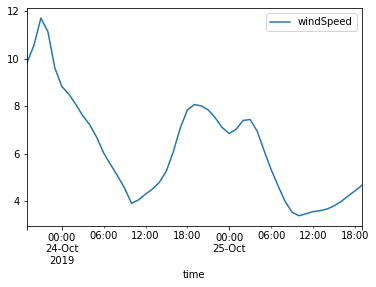

In [10]:
def plot_windspeed(dataframe):
    folder_name = 'darksky_data/output_data/{0}'.format(current_date_time)
    filename = os.path.join(folder_name, 'windspeed.png.png')
    df.plot.line(x='time', y='windSpeed')
    plt.savefig(filename)
    
plot_windspeed(df)

## Compile the functions into a single file (5 minutes)

We have been performing the operations one after the other in the above steps. Create a file called `process_weather_data.py` in your EC2 instance that contains all the functions we created so far. The file should look something like below:

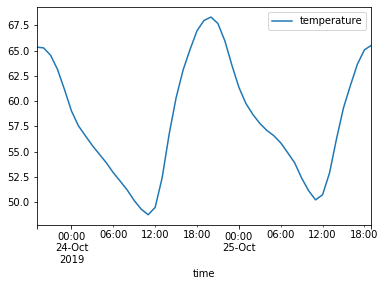

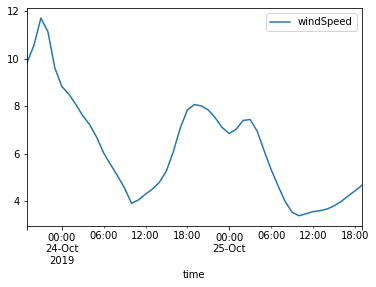

In [11]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt

current_date_time = None


def get_latest_weather_data():
    global current_date_time
    filename = 'darksky_data/raw_data/weather.json'
    with open(filename) as f:
        data = json.load(f)
        
    df = pd.DataFrame(data['hourly']['data'])
    
    # Convert time into a proper datetime object
    df['time'] = pd.to_datetime(df['time'], unit='s')
    
    # Set the current date time of the data in the global variable. This will be accessed later.
    current_date_time = datetime.datetime.fromtimestamp(data['currently']['time']).strftime('%Y_%m_%d_%H_%M')
    return df


def write_csv_file(dataframe):
    folder_name = 'darksky_data/output_data/{0}'.format(current_date_time)
    if not os.path.isdir(folder_name):
        os.makedirs(folder_name)
        
    filename = os.path.join(folder_name, 'output.csv')
    dataframe.to_csv(filename, index=False)
    

def calculate_temperature_stats(dataframe):
    temperature_data = {'stat': 'temperature'}
    temperature_data['max'] = dataframe['temperature'].max()
    temperature_data['min'] = dataframe['temperature'].min()
    temperature_data['average'] = dataframe['temperature'].mean()
    return temperature_data


def calculate_windspeed_stats(dataframe):
    temperature_data = {'stat': 'windspeed'}
    temperature_data['max'] = dataframe['windSpeed'].max()
    temperature_data['min'] = dataframe['windSpeed'].min()
    temperature_data['average'] = dataframe['windSpeed'].mean()
    return temperature_data


def plot_temperature(dataframe):
    folder_name = 'darksky_data/output_data/{0}'.format(current_date_time)
    filename = os.path.join(folder_name, 'temperature.png')
    df.plot.line(x='time', y='temperature')
    plt.savefig(filename)
    


def plot_windspeed(dataframe):
    folder_name = 'darksky_data/output_data/{0}'.format(current_date_time)
    filename = os.path.join(folder_name, 'windspeed.png')
    df.plot.line(x='time', y='windSpeed')
    plt.savefig(filename)
    
    
if True:  #__name__ == '__main__':
    df = get_latest_weather_data()
    write_csv_file(df)
    stats = []
    stats.append(calculate_temperature_stats(df))
    stats.append(calculate_windspeed_stats(df))

    # Write the stats to a csv file
    folder_name = 'darksky_data/output_data/{0}'.format(current_date_time)
    filename = os.path.join(folder_name, 'output.csv')
    pd.DataFrame(stats).to_csv(filename, index=False)
    plot_temperature(df)
    plot_windspeed(df)

## Create bash script and setup cronjob (10 minutes)

Now that we have both the Python files ready, create a new file called `process_weather_data.sh` and call both the Python files one after the other. The created file should have these lines:

    cd /home/ubuntu
    python fetch_weather_data.py
    python process_weather_data.py
    
    
After the file is created, convert the file to an executable format:

    chmod +x process_weather_data.sh
    
Now this file is executable and can be run as a bash script. Let's test it by removing the `darksky_data` folder and running the file to make sure everything works fine.

    rm -rf darksky_data
    ./process_weather_data.sh
    
Make sure the darksky_data folder is created with raw_data and output_data folders inside it.

If the file works as expected, let's create a cronjob that would execute the file every hour, so that the data gets stored in the instance every hour. Some basics on cron jobs can be found here - https://www.ostechnix.com/a-beginners-guide-to-cron-jobs/. In order to edit the cron jobs file, type the following command:

    crontab -e
    
This will open a file that shows the list of cronjobs configured. Add the following line to the end of the file:

    0 * * * * /home/ubuntu/process_weather_data.sh
    
Once the line is added, you can save and exit out of the file. We have now successfully configured the system to execute both the python scripts every hour, and the timestamped file and folder names will make sure we get access to hourly data even long after they are fetched.

## Conclusion (5 minutes)

In this case, we learned how to use requests library to fetch data from API, store it in a file, manipulate it to get some proper information out of it. We also learned about cronjobs and how they can be useful to schedule commands to be executed at specific time periods. 

We had to make sure the data fetched every time is properly timestamped, as the data should not be overwritten when the process runs next time.

## Takeaways (5 minutes)

When working with period recurring data, there are a few items to keep in mind:

- The data should be stored in a timestamped format (like the timstamp added at the end of the filename, or in the folder name)
- When programatically accessing files from the previous step, we should ensure that the latest file is easily accessible (Like naming the file `weather.json` without the timestamp.)
